# Logistic Regression in TensorFlow

- Use eager execution

In [1]:
# Use CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

In [2]:
import tensorflow as tf

In [3]:
print('TensorFlow version: %s' % tf.__version__)

TensorFlow version: 1.15.0


In [4]:
tf.enable_eager_execution()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.special import logit

In [6]:
np.random.seed(456)
tf.set_random_seed(456)

- Generate synthetic data

In [7]:
N = 100

In [8]:
# Zeros form a Gaussian centered at (-1, -1)
x_zeros = np.random.multivariate_normal(
    mean=np.array((-1, -1)), cov=.1*np.eye(2), size=(N//2,)).astype(np.float32)
y_zeros = np.zeros((N//2,), dtype=np.float32)

# Ones form a Gaussian centered at (1, 1)
x_ones = np.random.multivariate_normal(
    mean=np.array((1, 1)), cov=.1*np.eye(2), size=(N//2,)).astype(np.float32)
y_ones = np.ones((N//2,), dtype=np.float32)

x_np = np.vstack([x_zeros, x_ones])
y_np = np.concatenate([y_zeros, y_ones])

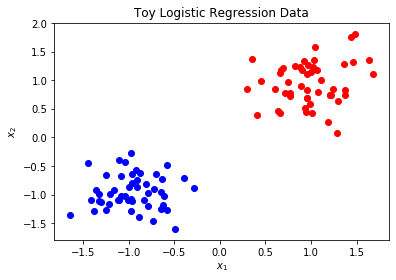

In [9]:
# Save image of the data distribution
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Toy Logistic Regression Data")

# Plot Zeros
plt.scatter(x_zeros[:, 0], x_zeros[:, 1], color="blue")
plt.scatter(x_ones[:, 0], x_ones[:, 1], color="red")
plt.savefig("logistic_data.png")

In [10]:
x = tf.convert_to_tensor(x_np)
y = tf.convert_to_tensor(y_np)

In [11]:
W = tf.Variable(tf.random_normal((2, 1)))
b = tf.Variable(tf.random_normal((1,)))

In [12]:
# Optimizer
train_op = tf.train.AdamOptimizer(.01)

In [13]:
summary_writer = tf.contrib.summary.create_file_writer('/tmp/logistic-train')

W1023 18:31:51.716418  1888 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [14]:
n_steps = 1000

# Train model
with summary_writer.as_default(), tf.contrib.summary.always_record_summaries():
    for i in range(n_steps):
        with tf.GradientTape() as tape:
            y_logit = tf.squeeze(tf.matmul(x, W) + b)
            y_one_prob = tf.sigmoid(y_logit)
            # Rounding P(y=1) will give the correct prediction.
            y_pred = tf.round(y_one_prob)

            # Compute the cross-entropy term for each datapoint
            entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_logit, labels=y)
            # Sum all contributions
            l = tf.reduce_sum(entropy)

            # Log
            tf.contrib.summary.scalar("loss", l, step=i)

            grads = tape.gradient(l, (W, b) )
            train_op.apply_gradients(zip(grads, (W, b)))

            if i % 100 == 0:
                print('step(%d): loss = %f' % (i, l) )

W1023 18:31:54.073056  1888 deprecation.py:323] From D:\Program\miniconda3\envs\tf\lib\site-packages\tensorflow_core\python\ops\nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


step(0): loss = 69.433105
step(100): loss = 16.942169
step(200): loss = 7.898455
step(300): loss = 4.878639
step(400): loss = 3.410726
step(500): loss = 2.557684
step(600): loss = 2.007708
step(700): loss = 1.627855
step(800): loss = 1.352197
step(900): loss = 1.144509


In [15]:
summary_writer.flush()
summary_writer.close()

In [16]:
W_final, b_final = W.numpy(), b.numpy()

In [17]:
# Make Predictions
y_logit = tf.squeeze(tf.matmul(x, W_final) + b_final)
y_one_prob = tf.sigmoid(y_logit)
y_pred_np = tf.round(y_one_prob)

In [18]:
score = accuracy_score(y_np, y_pred_np)
print("Classification Accuracy: %f" % score)

Classification Accuracy: 1.000000


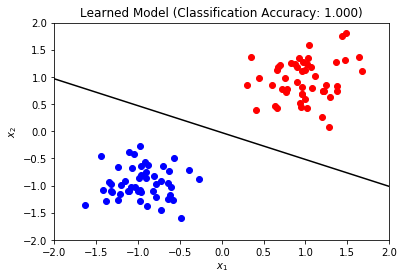

In [19]:
plt.clf()
# Save image of the data distribution
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Learned Model (Classification Accuracy: " + str("%.3f" % score) + ")")
plt.xlim(-2, 2)
plt.ylim(-2, 2)

# Plot Zeros
plt.scatter(x_zeros[:, 0], x_zeros[:, 1], color="blue")
plt.scatter(x_ones[:, 0], x_ones[:, 1], color="red")

x_left = -2
y_left = (1./W_final[1]) * (-b_final + logit(.5) - W_final[0]*x_left)

x_right = 2
y_right = (1./W_final[1]) * (-b_final + logit(.5) - W_final[0]*x_right)
plt.plot([x_left, x_right], [y_left, y_right], color='k')

plt.savefig("logistic_pred.png")